### Import

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import matplotlib.pyplot as plt
import multiprocessing as mp
import numpy as np
import pandas as pd
import seaborn as sns
import os

from functools import reduce
from tqdm import tqdm, tqdm_pandas
# from tqdm._tqdm_notebook import tqdm_notebook

In [3]:
tqdm.pandas()

### Constant

In [4]:
base_path = '../dataset/database_local'
# base_path = '../dataset/database'

In [5]:
flight_runway_file = base_path + '/04_flights_with_runway.csv'
landing_runway_file = base_path + '/04_landing_count_detail.csv'
all_fdm_file = base_path + '/06_all_crucial_fdm.csv'
output_flap_file = base_path + '/07_param_flap.csv'

# Read Data

#### 1. Read All Crucial FDM Flight

In [6]:
all_fdm = pd.read_csv(all_fdm_file, index_col=0)
display(all_fdm.head())
print(all_fdm.shape)

,hbaro_m,hdot_1_mps,flap_te_pos,gs_dev_ddm,gs_mps,loc_dev_ddm,lg_squat_mr,n11_rpm,n12_rpm,n13_rpm,n14_rpm,theta_rad,hralt_m,tas_mps,chi_rad,file
56716,999.1344,-3.73888,NaN,NaN,96.32889,NaN,NaN,34.03125,33.125,33.18750,34.15625,-0.021283,810.768,96.746872,-3.042753,686200104121825.csv
56717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,686200104121825.csv
56718,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.021283,810.768,NaN,NaN,686200104121825.csv
56719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,686200104121825.csv
56720,998.2200,-3.49504,2436.0,-0.33384,96.07167,-0.365736,0.0,34.03125,33.125,33.21875,34.15625,-0.021092,810.768,96.586110,-3.040452,686200104121825.csv


(800, 16)


In [7]:
test = all_fdm[['flap_te_pos']].dropna() / 100
test['flap_te_pos_flag'] = test['flap_te_pos'].map(lambda x: 0 if x >= 30 else 1)
test.head()

,flap_te_pos,flap_te_pos_flag
56720,24.36,1
56736,24.36,1
56752,24.36,1
56768,24.36,1
56784,24.36,1


# Transform Data

### Parameter Function
Determine if a flight is unstable or stable. Steps:
1. Convert `flap_te_pos` to degrees by dividing with 100
2. Unstable condition: `flap_te_pos < 30` for 5s consecutive
    - Search for value < 30, if the next 5 consecutive is still < 30 then unstable, else stable.

In [78]:
list_a = [0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1]

def find_n_consecutive_flag(flag_list: list, n: int) -> bool:
    if len(flag_list) < n:
        return(False)
    for i in range(len(flag_list) - (n - 1)):
        if flag_list[i] == 0:
            continue
        sum_flag = sum(flag_list[i:i+n])
        if sum_flag == n:
            return(True)
    return(False)

find_n_consecutive_flag(list_a, 5)

True

In [9]:
def detect_flap_unstable(df):
    cleaned_flaps = df.flap_te_pos.dropna()
    flap_deg = cleaned_flaps / 100
    sns.lineplot(data=flap_deg.reset_index(drop=True), lw=0.25, color='#1f77b4')
    flap_flag = list(flap_deg < 30)
    is_unstable = find_n_consecutive_flag(flap_flag, n=5)
    return int(is_unstable)

##### Test Function on DF 

In [10]:
stable_file = '687200109140645.csv'
unstable_file = '687200312291858.csv'

1. Stable FDM

<AxesSubplot:>

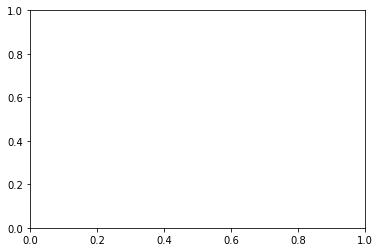

In [13]:
stable_fdm = all_fdm[all_fdm['file'] == stable_file]
sns.lineplot(data=stable_fdm.flap_te_pos/100)

False

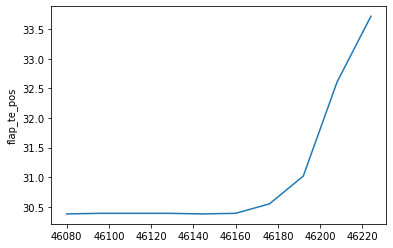

In [215]:
detect_flap_unstable(stable_fdm)

5. Unstable FDM

<AxesSubplot:ylabel='flap_te_pos'>

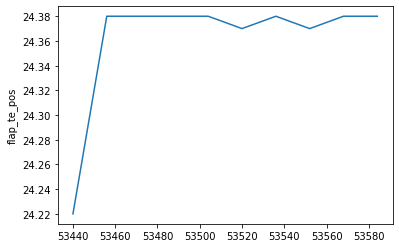

In [198]:
unstable_fdm = all_fdm[all_fdm['file'] == unstable_file]
sns.lineplot(data=unstable_fdm.flap_te_pos/100)

In [199]:
detect_flap_unstable(unstable_fdm)

True

### Detect for All FDM

100%|██████████| 5/5 [00:00<00:00, 36.20it/s]


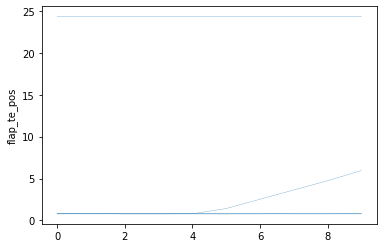

In [11]:
unstable_detection = all_fdm.groupby('file').progress_apply(detect_flap_unstable)

In [12]:
print(f"{sum(unstable_detection)}/{len(unstable_detection)}")

5/5


In [13]:
unstable_detection

file
686200104121245.csv    1
686200104121532.csv    1
686200104121825.csv    1
686200104130429.csv    1
686200104130652.csv    1
dtype: int64

In [14]:
unstable_detection_df = pd.DataFrame(unstable_detection, columns=['flap'])
unstable_detection_df.head()

,flap
file,
686200104121245.csv,1
686200104121532.csv,1
686200104121825.csv,1
686200104130429.csv,1
686200104130652.csv,1


In [24]:
unstable_detection_df.to_csv(output_flap_file)

# Param 2: Gamma

### Parameter Function
- Find gamma value using `gamma_rad = arcsin(hdot_1_mps/gs_mps)`
- Convert rad to degree
- up_bound = -1.0, lw_bound = -5.0

In [21]:
all_fdm.gs_mps.dropna()

56716      96.328890
56720      96.071670
56724      96.071670
56728      95.943060
56732      95.750145
             ...    
146332    109.511415
146336    109.382805
146340    109.318500
146344    109.318500
146348    109.189890
Name: gs_mps, Length: 200, dtype: float64

In [22]:
all_fdm.hdot_1_mps.dropna()

56716     -3.73888
56720     -3.49504
56724     -3.41376
56728     -3.25120
56732     -3.41376
            ...   
146332   -11.46048
146336   -11.05408
146340   -11.37920
146344   -10.89152
146348   -11.05408
Name: hdot_1_mps, Length: 200, dtype: float64

In [84]:
def detect_gamma_unstable(df):
    """
    Return 1 if flight is unstable or 0 if flight is stable, based on gamma parameter.
    gamma_rad = arcsin(hdot_1_mps/gs_mps)
    Unstable if gamma_deg > -1.0 or gamma_deg < -5.0
    """
    # Clean df
    cleaned_gs_mps = df.gs_mps.dropna()
    cleaned_hdot = df.hdot_1_mps.dropna()
    
    # Convert to gamma_deg
    gamma_rad = np.arcsin(cleaned_hdot/cleaned_gs_mps)
    gamma_deg = gamma_rad.map(math.degrees)
    
    # Flag unstable flight
    gamma_flag = list((gamma_deg > -1) | (gamma_deg < -5))
    
    # Display plot
    sns.lineplot(data=gamma_deg.reset_index(drop=True), lw=0.25, color='#1f77b4')
    
    # Determine unstable or stable
    is_unstable = find_n_consecutive_flag(gamma_flag, 5)
    return int(is_unstable)

In [80]:
detect_gamma_unstable(all_fdm[all_fdm['file'] == '686200104121825.csv'])

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]


0

100%|██████████| 5/5 [00:00<00:00, 30.23it/s]


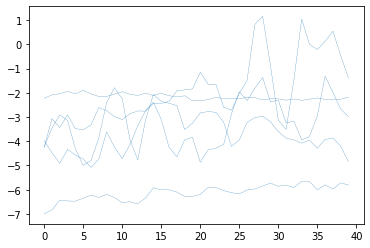

In [85]:
unstable_gamma_detection = all_fdm.groupby('file').progress_apply(detect_gamma_unstable)

In [87]:
unstable_detection_df['gamma'] = unstable_gamma_detection
unstable_detection_df

,flap,gamma
file,,
686200104121245.csv,1,0
686200104121532.csv,1,1
686200104121825.csv,1,0
686200104130429.csv,1,0
686200104130652.csv,1,1
